# Initializations

In [1]:
import numpy as np
import pandas as pd

import sys, os, time
import glob

from matplotlib import pyplot as plt
%matplotlib inline

# these magics ensure that external modules that are modified are also automatically reloaded
%load_ext autoreload
%autoreload 2

# widgets and interaction
from ipywidgets import FloatProgress
from IPython.display import display, clear_output

import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})

import warnings
warnings.filterwarnings('ignore')

import gzip
import cPickle as pickle

In [3]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision.utils as vutils
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.autograd import Variable

import sys
sys.path.append("../models/")

import models.dcgan as dcgan
import models.mlp as mlp
import models.dcgan_orig as do

# Set up data sources

In [4]:
dataroot = "/home/data/world-cities/"

#### Training data is in ./train (all cities > 10k population)

In [185]:
import glob

files = glob.glob(dataroot + "/train/*/*.png")
files_df = []
for f in files:
    s = f.split("/")
    fname, cls = s[-1], s[-2]
    _,country,city,_,pop,lat,lon = fname.split("_")
    files_df.append((f, cls, country, pop))
    
files_df = pd.DataFrame(files_df, \
                columns=["filename", "class", "country", "population"])
files_df['city'] = files_df['filename'].apply(lambda s: os.path.basename(s).split("_")[2].replace("-"," "))
files_df['phase'] = 'train'

len(files_df)

24986

#### Test data is under ./test/ and contains more carefully-filtered samples

In [186]:
files = glob.glob(dataroot + "/test/*/*.png")
test_df = []
for f in files:
    s = f.split("/")
    fname, cls = s[-1], s[-2]
    _,country,city,_,pop,lat,lon = fname.split("_")
    test_df.append((f, cls, country, pop))
    
test_df = pd.DataFrame(test_df, \
                columns=["filename", "class", "country", "population"])

# hack to remove some cities that are too close to Paris
# just an example we looked at
# this means that the filtering needs to be debugged
test_df = test_df[(~test_df['filename'].str.contains("argenteuil")) & \
                  (~test_df['filename'].str.contains("montreuil"))]

test_df['city'] = test_df['filename'].apply(lambda s: os.path.basename(s).split("_")[2].replace("-"," "))
test_df['phase'] = 'test'

len(test_df)

3010

In [187]:
files_df = pd.concat([files_df, test_df], axis=0).reset_index().drop("index",1)

#### Add in region information

In [188]:
regions_df = pd.read_csv("/home/data/countries_regions.csv")

country2region = {r:c for r,c in zip(regions_df['alpha-2'].str.lower(), regions_df['region'])}

files_df['region'] = files_df['country'].apply(lambda x: country2region[x] if x in country2region else np.nan)


# Compute stats on each image
Possibly do this at different scales

In [201]:
%%px --local

from skimage import morphology
from skimage.transform import resize
from skimage.io import imread, imsave
import numpy as np

def compute_patch_areas(M):
    mask = morphology.label(M)
    areas = []
    for i in np.arange(1,mask.max()):
        areas.append((i,(mask==i).sum()))
    areas.sort(key=lambda x: x[1], reverse=True)
    return areas, mask

compute_pct_occupied = lambda img: (img/255.0).sum() / float(img.shape[0]*img.shape[1])

def compute_stats(f, imgSize=None):
    img = imread(f)
    img[img==128] = 0 # this removes gray patches that indicate no data/water bodies
    # img = img / 255.0
    if imgSize is not None:
        img = resize(img, (imgSize, imgSize), preserve_range=True)
        
    pct_occupied = compute_pct_occupied(img)
    patch_areas, mask = compute_patch_areas(img)
    n_areas = 20
    top_patch_areas = np.zeros(n_areas).astype(int)
    k = min([n_areas,len(patch_areas)])
    top_patch_areas[:k] = [x[1] for x in patch_areas[:k]]
    
    return {"filename":f,
            "built pct": pct_occupied,
            "patch areas": top_patch_areas}

0.0255529946354


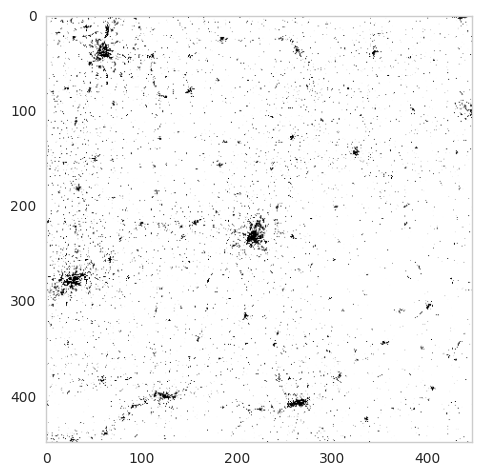

In [174]:
f = files_df.sample()['filename'].iloc[0]
img = imread(f)
print compute_pct_occupied(img)

plt.imshow(img)

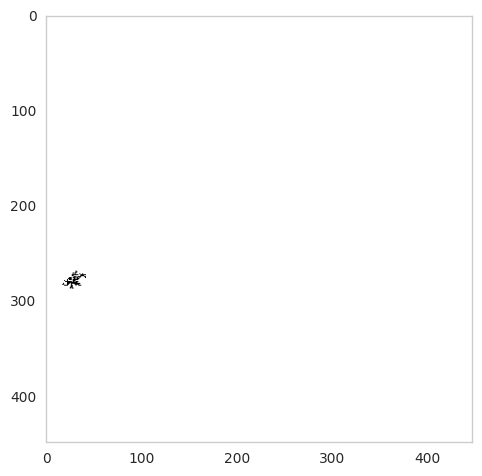

In [175]:
areas, mask = compute_patch_areas(img)

mask1 = mask.copy()
mask1[mask1!=areas[0][0]] = 0
plt.imshow(mask1)

0.0264016544118


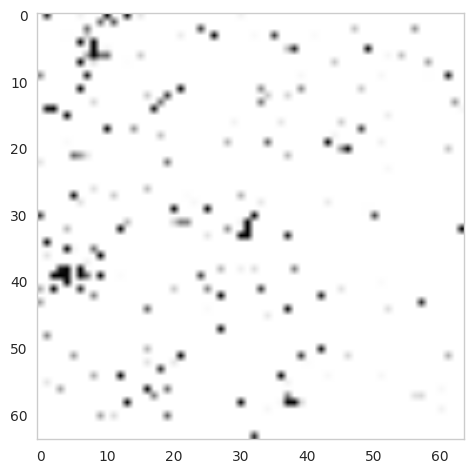

In [176]:
img_small = resize(img, (64,64), preserve_range=True)
print compute_pct_occupied(img_small)
plt.imshow(img_small)

In [195]:
(img_small / 255.0).sum()/(64**2)

0.026401654411764727

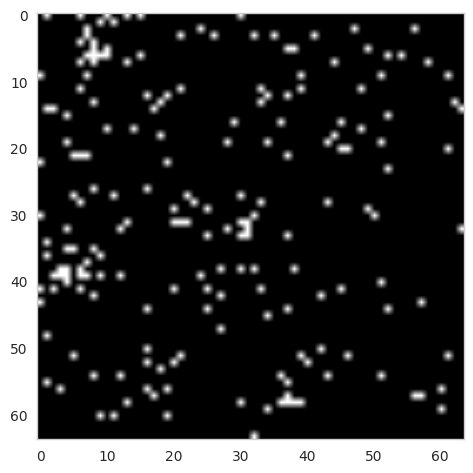

In [200]:
areas, mask = compute_patch_areas(img_small + 1)

mask1 = mask.copy()
mask1[mask1!=areas[0][0]] = 0
plt.imshow(mask1)

In [47]:
%%timeit 
files_df['filename'].iloc[:10].apply(compute_stats)

1 loop, best of 3: 12.2 s per loop


In [48]:
from IPython import parallel

rc = parallel.Client()
all_engines = rc[:]
lbv = rc.load_balanced_view()

print len(all_engines)

48


In [179]:
res_orig = lbv.map_async(compute_stats, files_df['filename'])

In [180]:
res_thum = lbv.map_async(lambda f: compute_stats(f, 64), files_df['filename'])

In [189]:
stats_orig = pd.DataFrame(res_orig.result())\
    .rename(columns={"built pct":"build pct 448", "patch areas":"patch areas 448"})
stats_thum = pd.DataFrame(res_thum.result())\
    .rename(columns={"built pct":"build pct 64", "patch areas":"patch areas 64"})

files_df = pd.concat([files_df, \
                      stats_orig.drop("filename",1), stats_thum.drop("filename",1)], 
                     axis=1)

#### Preprocessing: assign class of "built area"
- by deciles

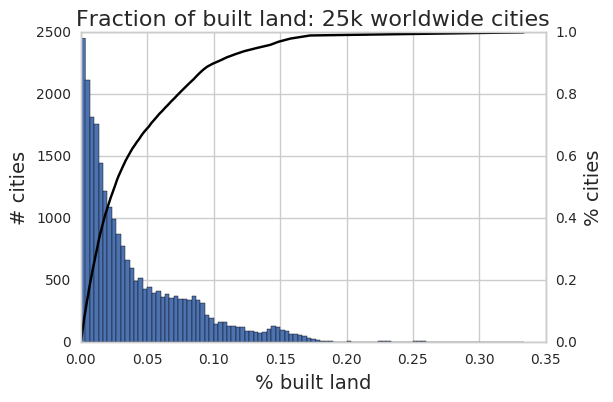

In [203]:
fig, ax = plt.subplots(figsize=(6,4))
ax2 = ax.twinx()
files_df[files_df['phase']=='train']['build pct 64'].hist(bins=100, ax=ax)
q = files_df[files_df['phase']=='train']['build pct 64'].quantile(np.linspace(0.0,1,100))
ax2.plot(q, q.index, label="cdf", color="black")
sns.set_style("whitegrid", {'axes.grid' : False})
plt.title("Fraction of built land: 25k worldwide cities", fontsize=16)
ax.set_xlabel("% built land", fontsize=14)
ax.set_ylabel("# cities", fontsize=14)
ax2.set_ylabel("% cities", fontsize=14)


In [183]:
q = files_df['build pct 64'].quantile(np.linspace(0.0,1,10))

print q

files_df['decile'] = files_df['build pct 64'].apply(lambda x: np.searchsorted(q.values, x) )

          build pct 64  build pct 64
0.000000      0.000000      0.000000
0.111111      0.002918      0.000011
0.222222      0.006991      0.000027
0.333333      0.012207      0.000048
0.444444      0.018497      0.000073
0.555556      0.027592      0.000108
0.666667      0.041807      0.000164
0.777778      0.064567      0.000253
0.888889      0.092421      0.000362
1.000000      0.333381      0.001307


ValueError: ('object too deep for desired array', u'occurred at index build pct 64')

# Save to file

In [ ]:
train_df = files_df[(files_df['phase']=='train') & (files_df['build pct 64']>0.02)]
train_df.to_csv(dataroot + "/train-2pct.csv")

test_df = files_df[(files_df['phase']=='test')]
train_df.to_csv(dataroot + "/test.csv")

len(train_df), len(valid_df)

In [ ]:
test_df['built pct 448'].hist(bins=100, figsize=(6,4))
plt.title("Fraction of built land: 3k global cities", fontsize=16)
plt.xlabel("% built land", fontsize=14)
plt.ylabel("# cities", fontsize=14)